In [1]:
import json

def load_log(file_path):
    """Читает лог из файла."""
    log_data = []
    with open(file_path, 'r') as file:
        for line in file:
            tr  = json.loads(line.strip())
            l = abs( tr['start_frame'] -  tr['last_frame']) 
            if l > 3: 
                log_data.append(tr)
    return  sorted(log_data, key=lambda d: d['start_frame']) 


file_path = '/home/nssd/gled/vb/dataset-vb/backline/g_4m2w_transmash_20250516_1.txt'
video_path = '/home/nssd/gled/vb/dataset-vb/backline/g_4m2w_transmash_20250516_1.mp4'
tracks = load_log(file_path)

for i in tracks:
    print('Track', i['start_frame'], ' - ', i['last_frame'], 'len  = ',i['start_frame'] -  i['last_frame'])

Track 6  -  582 len  =  -576
Track 589  -  594 len  =  -5
Track 679  -  832 len  =  -153
Track 1436  -  1715 len  =  -279
Track 1741  -  1975 len  =  -234
Track 2585  -  2931 len  =  -346
Track 2937  -  2941 len  =  -4
Track 3504  -  3555 len  =  -51
Track 3599  -  3690 len  =  -91
Track 4042  -  5337 len  =  -1295
Track 5195  -  5201 len  =  -6
Track 5356  -  5404 len  =  -48
Track 5610  -  5790 len  =  -180
Track 5808  -  5838 len  =  -30
Track 5843  -  5866 len  =  -23
Track 5943  -  6023 len  =  -80
Track 6160  -  8197 len  =  -2037
Track 6164  -  6173 len  =  -9
Track 7162  -  7173 len  =  -11
Track 8290  -  8403 len  =  -113
Track 8416  -  8482 len  =  -66
Track 8799  -  9094 len  =  -295
Track 9186  -  9285 len  =  -99
Track 9613  -  10382 len  =  -769
Track 9615  -  9638 len  =  -23
Track 10408  -  11093 len  =  -685
Track 11214  -  11358 len  =  -144
Track 11713  -  12248 len  =  -535
Track 12296  -  12313 len  =  -17
Track 12454  -  12603 len  =  -149
Track 13002  -  13008 le

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import HTML
import cv2
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import matplotlib
matplotlib.rcParams['animation.embed_limit'] = 2**128

def load_to_dataframe(data, touch_threshold=0.5):
    positions_data = []
    for pos in data['positions']:
        positions_data.append({
            'x': pos[0][0],
            'y': pos[0][1],
            'frame': pos[1]
        })
    
    df = pd.DataFrame(positions_data).sort_values('frame')
    
    # Вычисляем производные движения
    df['v_x'] = df['x'].diff() / df['frame'].diff()
    df['v_y'] = df['y'].diff() / df['frame'].diff()
    df['v_xy'] = np.sqrt(df['v_x']**2 + df['v_y']**2)
    
    df['a_x'] = df['v_x'].diff() / df['frame'].diff()
    df['a_y'] = df['v_y'].diff() / df['frame'].diff()
    df['a_xy'] = np.sqrt(df['a_x']**2 + df['a_y']**2)
    
    df['angle'] = np.degrees(np.arctan2(df['v_y'], df['v_x'])) % 360
    df['angular_velocity'] = df['angle'].diff() / df['frame'].diff()
    
    # Детекция касаний
    df['acceleration_change'] = df['a_xy'].abs()
    df['angle_change'] = abs(df['angular_velocity'])
    
    # Комбинированный показатель изменения траектории
    df['trajectory_change'] = (
        df['acceleration_change'] / df['acceleration_change'].mean() + 
        df['angle_change'] / df['angle_change'].mean()
    )
    
    # Определяем кадры с касаниями
    df['is_touch'] = False
    if len(df) > 1:
        mean_change = df['trajectory_change'].mean()
        std_change = df['trajectory_change'].std()
        threshold = mean_change + touch_threshold * std_change
        
        # Находим кадры с аномальными изменениями траектории
        touch_frames = df[df['trajectory_change'] > threshold]['frame']
        df.loc[df['frame'].isin(touch_frames), 'is_touch'] = True
    
    if 'prediction' in data:
        prediction = data['prediction']
        prediction_frame = df['frame'].max() + 1
        last_row = df.iloc[-1]
        
        pred_df = pd.DataFrame([{
            'x': prediction[0],
            'y': prediction[1],
            'frame': prediction_frame,
            'is_prediction': True,
            'is_touch': False,
            **{k: last_row[k] for k in ['v_x', 'v_y', 'v_xy', 
                                       'a_x', 'a_y', 'a_xy',
                                       'angle', 'angular_velocity']}
        }])
        
        df = pd.concat([df, pred_df], ignore_index=True)
    
    return df


# Функция для загрузки кадров видео
def load_video_frames(video_path, frame_numbers):
    cap = cv2.VideoCapture(video_path)
    frames = {}
    
    for fn in frame_numbers:
        cap.set(cv2.CAP_PROP_POS_FRAMES, fn)
        ret, frame = cap.read()
        if ret:
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            frames[fn] = frame
    
    cap.release()
    return frames

In [15]:

{"positions": [[[1065.0, 754.5, 538.4615384615385], 161], [[1067.5, 775.5, 567.5675675675676], 162]], "prediction": [1070.0, 796.5, 596.6735966735968], "last_frame": 162, "start_frame": 161, "ball_sizes": [39, 37]}


{'positions': [[[1065.0, 754.5, 538.4615384615385], 161],
  [[1067.5, 775.5, 567.5675675675676], 162]],
 'prediction': [1070.0, 796.5, 596.6735966735968],
 'last_frame': 162,
 'start_frame': 161,
 'ball_sizes': [39, 37]}

In [9]:


# Пример данных
data = {
    "positions": [
        [[1065.0, 754.5, 538.4615384615385], 161], 
        [[1067.5, 775.5, 567.5675675675676], 162],
        [[1070.0, 790.0, 590.0], 163],
        [[1072.5, 800.0, 610.0], 164],
        [[1075.0, 810.0, 630.0], 165],
        [[1077.5, 820.0, 650.0], 166],
        [[1080.0, 830.0, 670.0], 167],
        [[1082.5, 840.0, 690.0], 168],
        [[1085.0, 850.0, 710.0], 169],
        [[1087.5, 860.0, 730.0], 170],
        [[1090.0, 870.0, 750.0], 171],
        [[1092.5, 880.0, 770.0], 172]
    ], 
    "prediction": [1095.0, 890.0, 790.0], 
    "last_frame": 172, 
    "start_frame": 161, 
    "ball_sizes": [39, 37]
}

# Загрузка данных
data = tracks[1]
df = load_to_dataframe(data)

# Путь к видеофайлу (замените на ваш путь)
#video_path = "ball_tracking.mp4"  # или любой другой видеофайл

# Создание анимации с видео


In [10]:
df


,x,y,frame,v_x,v_y,v_xy,a_x,a_y,a_xy,angle,angular_velocity,acceleration_change,angle_change,trajectory_change,is_touch,is_prediction
0,922.5,606.5,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,NaN
1,922.0,607.0,7,-0.5,0.5,0.707107,NaN,NaN,NaN,135.000000,NaN,NaN,NaN,NaN,False,NaN
2,922.0,608.0,8,0.0,1.0,1.000000,0.5,0.5,0.707107,90.000000,-45.000000,0.707107,45.000000,2.276568,False,NaN
3,922.0,608.5,9,0.0,0.5,0.500000,0.0,-0.5,0.500000,90.000000,0.000000,0.500000,0.000000,0.205693,False,NaN
4,921.5,608.0,10,-0.5,-0.5,0.707107,-0.5,-1.0,1.118034,225.000000,135.000000,1.118034,135.000000,6.416966,True,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
474,895.0,569.5,579,-13.5,13.0,18.741665,-1.5,4.5,4.743416,136.080924,-8.607862,4.743416,8.607862,2.331208,False,NaN
475,883.0,579.5,580,-12.0,10.0,15.620499,1.5,-3.0,3.354102,140.194429,4.113505,3.354102,4.113505,1.561345,False,NaN
476,867.5,593.5,581,-15.5,14.0,20.886599,-3.5,4.0,5.315073,137.910838,-2.283591,5.315073,2.283591,2.287315,False,NaN
477,850.0,609.0,582,-17.5,15.5,23.377339,-2.0,1.5,2.500000,138.468229,0.557391,2.500000,0.557391,1.053062,False,NaN


In [11]:
df = load_to_dataframe(data)
touch_frames = df[df['is_touch']]['frame'].tolist()

In [13]:
touch_frames

[10,
 67,
 68,
 69,
 70,
 117,
 167,
 176,
 181,
 247,
 248,
 281,
 282,
 284,
 285,
 286,
 313,
 323,
 324,
 352,
 353,
 354,
 355,
 357,
 365,
 445,
 446,
 451,
 529,
 563,
 564,
 567,
 568]

In [15]:
mean_change = df['trajectory_change'].mean()
mean_change

2.0

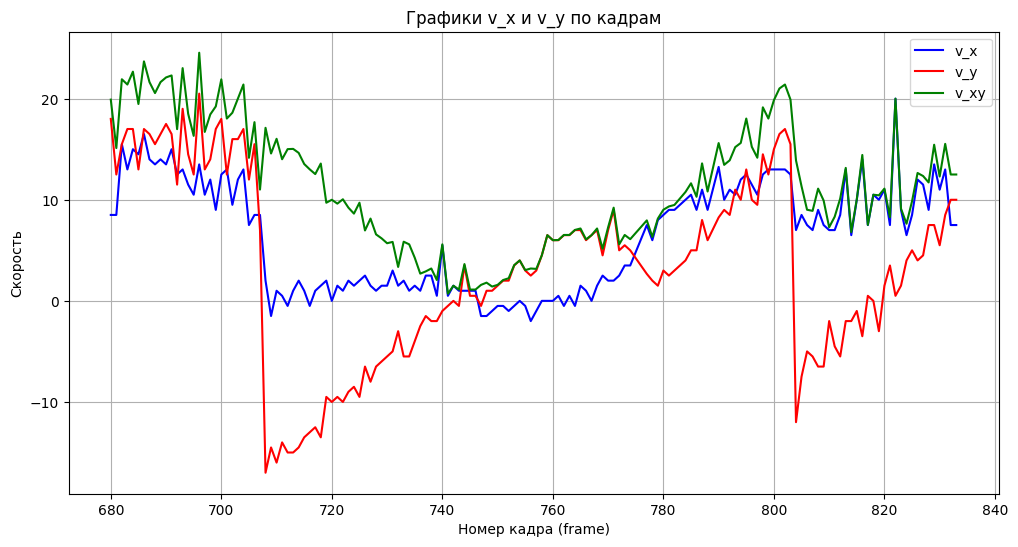

In [33]:
import matplotlib.pyplot as plt
import pandas as pd

data = tracks[2]
df = load_to_dataframe(data)

# Предполагаем, что ваш DataFrame называется df
# Если у вас другое название, замените df на ваше название

# Создаем фигуру и оси
plt.figure(figsize=(12, 6))

# График v_x по frame
plt.plot(df['frame'], df['v_x'], label='v_x', color='blue')

# График v_y по frame
plt.plot(df['frame'], df['v_y'], label='v_y', color='red')
# График v_xy по frame
plt.plot(df['frame'], df['v_xy'], label='v_xy', color='green')
# Настройки графика
plt.title('Графики v_x и v_y по кадрам')
plt.xlabel('Номер кадра (frame)')
plt.ylabel('Скорость')
plt.legend()
plt.grid(True)

# Показать график
plt.show()

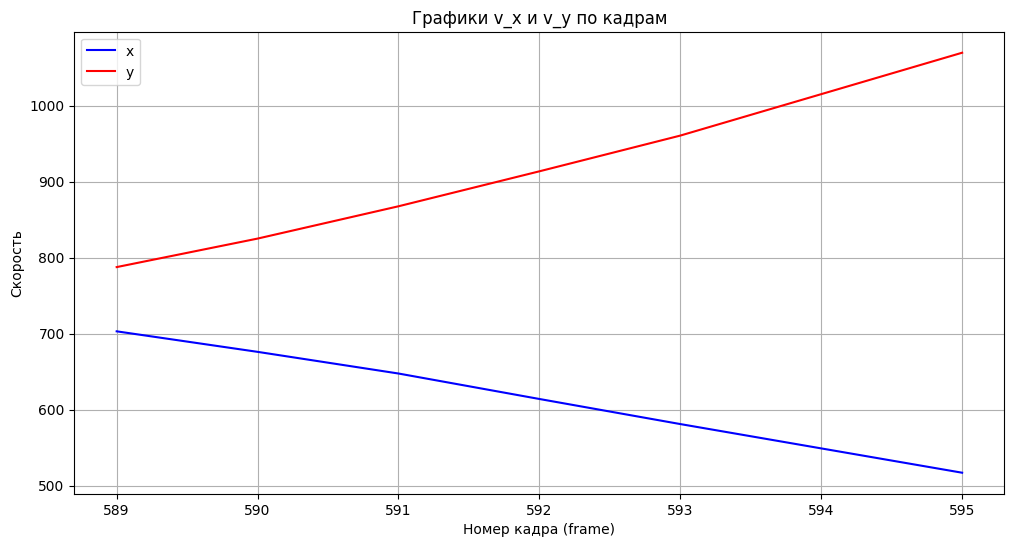

In [25]:
# Создаем фигуру и оси
plt.figure(figsize=(12, 6))

# График v_x по frame
plt.plot(df['frame'], df['x'], label='x', color='blue')

# График v_y по frame
plt.plot(df['frame'], df['y'], label='y', color='red')

# Настройки графика
plt.title('Графики v_x и v_y по кадрам')
plt.xlabel('Номер кадра (frame)')
plt.ylabel('Скорость')
plt.legend()
plt.grid(True)

# Показать график
plt.show()

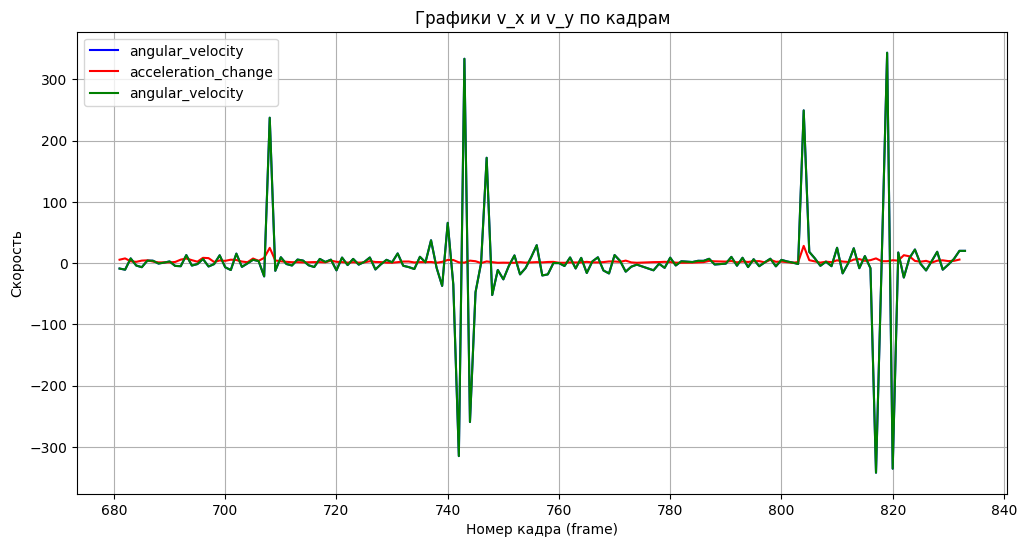

,x,y,frame,v_x,v_y,v_xy,a_x,a_y,a_xy,angle,angular_velocity,acceleration_change,angle_change,trajectory_change,is_touch,is_prediction
0,14.0,510.5,679,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,NaN
1,22.5,528.5,680,8.5,18.0,19.906029,NaN,NaN,NaN,64.722278,NaN,NaN,NaN,NaN,False,NaN
2,31.0,541.0,681,8.5,12.5,15.116216,0.0,-5.5,5.500000,55.784298,-8.937980,5.500000,8.937980,2.157836,False,NaN
3,46.5,556.5,682,15.5,15.5,21.920310,7.0,3.0,7.615773,45.000000,-10.784298,7.615773,10.784298,2.927596,False,NaN
4,59.5,573.5,683,13.0,17.0,21.400935,-2.5,1.5,2.915476,52.594643,7.594643,2.915476,7.594643,1.252098,False,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
146,968.0,986.0,829,13.5,7.5,15.443445,4.5,0.0,4.500000,29.054604,-10.750967,4.500000,10.750967,1.895790,False,NaN
147,979.0,991.5,830,11.0,5.5,12.298374,-2.5,-2.0,3.201562,26.565051,-2.489553,3.201562,2.489553,1.153260,False,NaN
148,992.0,1000.0,831,13.0,8.5,15.532225,2.0,3.0,3.605551,33.178512,6.613460,3.605551,6.613460,1.443158,False,NaN
149,999.5,1010.0,832,7.5,10.0,12.500000,-5.5,1.5,5.700877,53.130102,19.951591,5.700877,19.951591,2.641644,False,NaN


In [34]:
# Создаем фигуру и оси
plt.figure(figsize=(12, 6))


#angular_velocity	acceleration_change	angle_change	
# График v_x по frame
plt.plot(df['frame'], df['angular_velocity'], label='angular_velocity', color='blue')

# График v_y по frame
plt.plot(df['frame'], df['acceleration_change'], label='acceleration_change', color='red')
plt.plot(df['frame'], df['angular_velocity'], label='angular_velocity', color='green')

# Настройки графика
plt.title('Графики v_x и v_y по кадрам')
plt.xlabel('Номер кадра (frame)')
plt.ylabel('Скорость')
plt.legend()
plt.grid(True)

# Показать график
plt.show()
df


In [ ]:
d